## Bayesian Inference for the Experimental Results of Perceptual Study ##

This Jupyter Notebook serves to show the process by which we performed the Bayesian analysis of the data. We will be using PyMC3 to build probabilistic models.

Resources consulted to learn more about Bayesian Inference in general, as well as how to use PyMC (a Markov Chain Monte Carlo Library):  
https://docs.pymc.io/  
https://www.analyticsvidhya.com/blog/2016/06/bayesian-statistics-beginners-simple-english/  
https://www.youtube.com/watch?v=p1IB4zWq9C8&index=5&list=PL1Ma_1DBbE82OVW8Fz_6Ts1oOeyOAiovy  
https://docs.pymc.io/notebooks/Bayes_factor.html  

First, we will import the required libraries:

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt
import pymc3 as pm

print('Done.')

from scipy.special import betaln
import scipy.stats as ss

Done.


Now, we will read in the data.

To get an idea of the shape, we will visualize some histograms to see how the data are distributed.

In [120]:
# let's load the data, and for the overall analysis, split it into one array of errors per chart type.
# we will also normalize the values to be on the range of 0 to 1 to get some 


data = pd.read_csv('../subjectdata/master.csv')

barData = data[data['chartType']=='barChart']['error']/6.646
pieData = data[data['chartType']=='pieChart']['error']/6.646
roseData = data[data['chartType']=='roseChart']['error']/6.646

allData = np.array([barData.values, pieData.values, roseData.values])

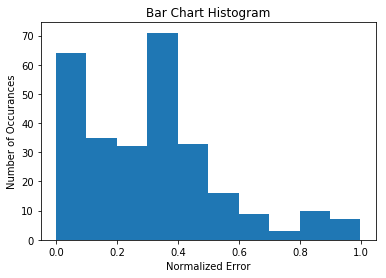

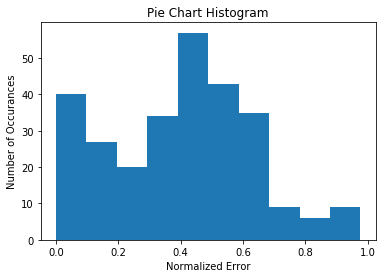

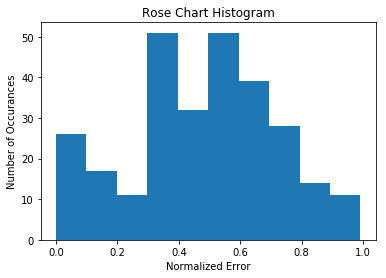

In [121]:
#print out the histogram of the data

plt.hist(barData.values)
plt.title('Bar Chart Histogram')
plt.xlabel('Normalized Error')
plt.ylabel('Number of Occurances')
plt.show()

plt.hist(pieData)
plt.title('Pie Chart Histogram')
plt.xlabel('Normalized Error')
plt.ylabel('Number of Occurances')
plt.show()

plt.hist(roseData)
plt.title('Rose Chart Histogram')
plt.xlabel('Normalized Error')
plt.ylabel('Number of Occurances')
plt.show()

Yikes, so it seems like some way we structured our experiment caused some weird data points where people can exactly guess the relative sizes very often.

to try to clean this, we will exlude data that corresponds to very small errors.


(216, 240, 254)


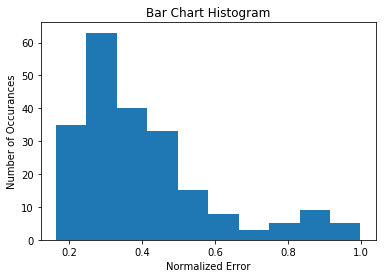

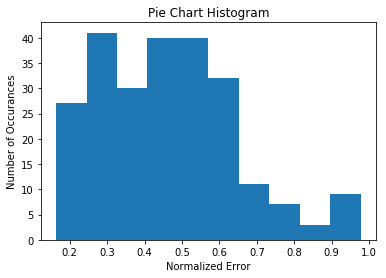

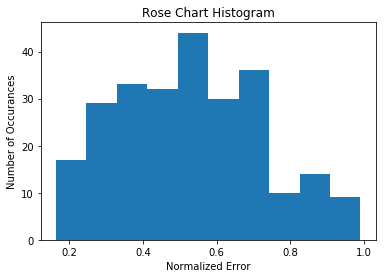

In [126]:
barDataFiltered = barData[barData > .03]
pieDataFiltered = pieData[pieData > .03]
roseDataFiltered = roseData[roseData > .03]

allData = np.array([barDataFiltered.values, pieDataFiltered.values, roseDataFiltered.values])

print(len(barDataFiltered),len(pieDataFiltered),len(roseDataFiltered))

plt.hist(barDataFiltered)
plt.title('Bar Chart Histogram')
plt.xlabel('Normalized Error')
plt.ylabel('Number of Occurances')
plt.show()

plt.hist(pieDataFiltered)
plt.title('Pie Chart Histogram')
plt.xlabel('Normalized Error')
plt.ylabel('Number of Occurances')
plt.show()

plt.hist(roseDataFiltered)
plt.title('Rose Chart Histogram')
plt.xlabel('Normalized Error')
plt.ylabel('Number of Occurances')
plt.show()

Next, we will set up the model to learn the parameters for the distribution our data follow.

We chose to model the distribution of error in guessing relative percentages as a beta distribution, for the following observations about our data:

1. The values that the data can take are continuous.
The input can be any number from 0-100, the actual value to be guessed can be any rational number from 0-100, and the error is calculated with a log, so the output is in the domain of real numbers.

2. The data are bounded from log2(0.125) to log2(100.125). 
Therefore we can rule out distributions that aren't bounded on both sides, because associating any non-zero probability to anything outside this range would not correctly model the data.

3. The distribution may not be symetrical about its mean.
There is likely to be some skew in the data which is typical of bounded data, especially when the mean is close to one of the endpoints. In these cases, the data are usually skewed away from the endpoints.

The beta distribution has an additional perk of a simple calculation for its mean [mean = a/(a+b)]

To be conservative, we consider a uniform distribution over the range of [1,100] to model the possible values of alpha and beta, since we do not want to introduce biases. The distribution for both alpha and beta are updated as samples are drawn from the data.

We also set up a deterministic variable that allows us to calculate the mean, and propagate the error from alpha and beta.

In [127]:
n_chains = 1000

models = []
traces = []
for chartTypeData in allData:
    with pm.Model() as model:
        #first we will set up the 
        a = pm.Uniform('alpha parameter', 1, 100)
        b = pm.Uniform('beta parameter', 1, 100)
        
        mean = pm.Deterministic('mean', a/(a+b))
        
        
        yl = pm.Beta('yl', a, b, observed=chartTypeData)
        trace = pm.sample(1000,
                          step=pm.SMC(),
                          random_seed=42)
        models.append(model)
        traces.append(trace)

Sample initial stage: ...
Stage: 0 Beta: 0.000512 Steps: 25
100%|██████████| 1000/1000 [00:01<00:00, 701.75it/s]
Stage: 1 Beta: 0.001403 Steps: 7
100%|██████████| 1000/1000 [00:00<00:00, 2137.28it/s]
Stage: 2 Beta: 0.003229 Steps: 3
100%|██████████| 1000/1000 [00:00<00:00, 4652.96it/s]
Stage: 3 Beta: 0.007738 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 3156.49it/s]
Stage: 4 Beta: 0.020901 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 3798.27it/s]
Stage: 5 Beta: 0.062454 Steps: 5
100%|██████████| 1000/1000 [00:00<00:00, 2746.76it/s]
Stage: 6 Beta: 0.219501 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 3774.90it/s]
Stage: 7 Beta: 0.767213 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 3779.16it/s]
Stage: 8 Beta: 1.000000 Steps: 4
100%|██████████| 1000/1000 [00:00<00:00, 3182.29it/s]
Sample initial stage: ...
Stage: 0 Beta: 0.000538 Steps: 25
100%|██████████| 1000/1000 [00:01<00:00, 655.76it/s]
Stage: 1 Beta: 0.001442 Steps: 7
100%|██████████| 1000/1000 [00:00<00:00, 2406

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha parameter,1.941409,0.170802,0.004929,1.602935,2.264473
beta parameter,2.757763,0.249652,0.007693,2.312074,3.273334
mean,0.413265,0.014008,0.000457,0.382687,0.437260


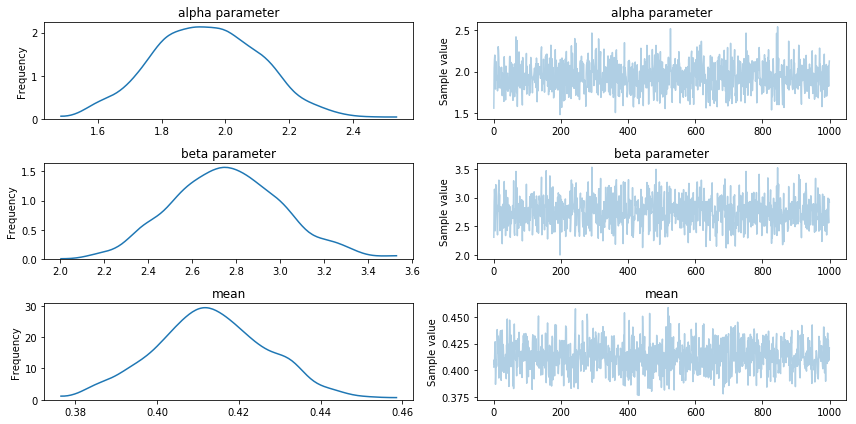

In [128]:
pm.traceplot(traces[0])
pm.summary(traces[0])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha parameter,2.523879,0.217667,0.006220,2.145418,2.957026
beta parameter,2.874068,0.257036,0.007584,2.404217,3.391922
mean,0.467653,0.012560,0.000376,0.442459,0.490579


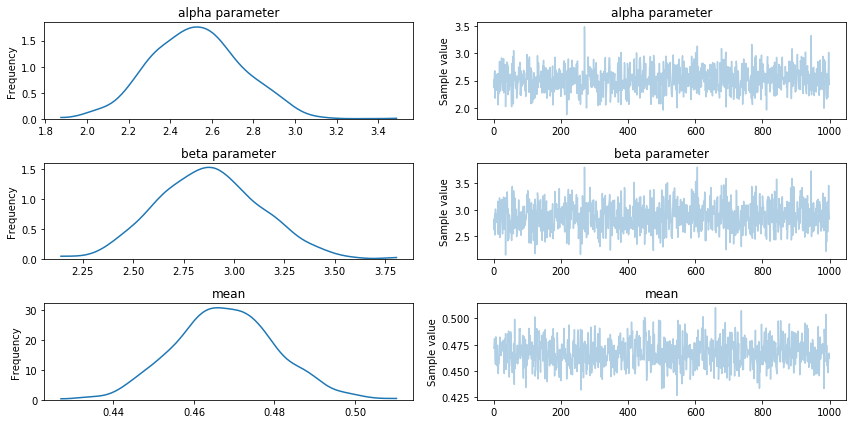

In [129]:
pm.traceplot(traces[1])
pm.summary(traces[1])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha parameter,2.723842,0.238843,0.007216,2.257819,3.174338
beta parameter,2.410351,0.211257,0.006335,1.956401,2.797891
mean,0.530511,0.012034,0.000343,0.506380,0.553463


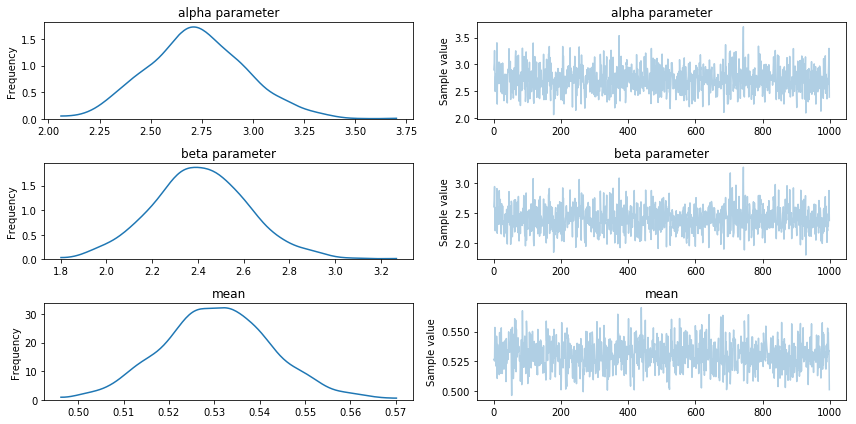

In [130]:
pm.traceplot(traces[2])
pm.summary(traces[2])

In [131]:
ppc_0 = pm.sample_posterior_predictive(traces[0], 100, models[0], size=(50, 20)) #size samples 50 points from 20 distributions (parameters are in that order)
ppc_1 = pm.sample_posterior_predictive(traces[1], 100, models[1], size=(50, 20))
ppc_2 = pm.sample_posterior_predictive(traces[2], 100, models[2], size=(50, 20))

100%|██████████| 100/100 [00:07<00:00, 14.30it/s]


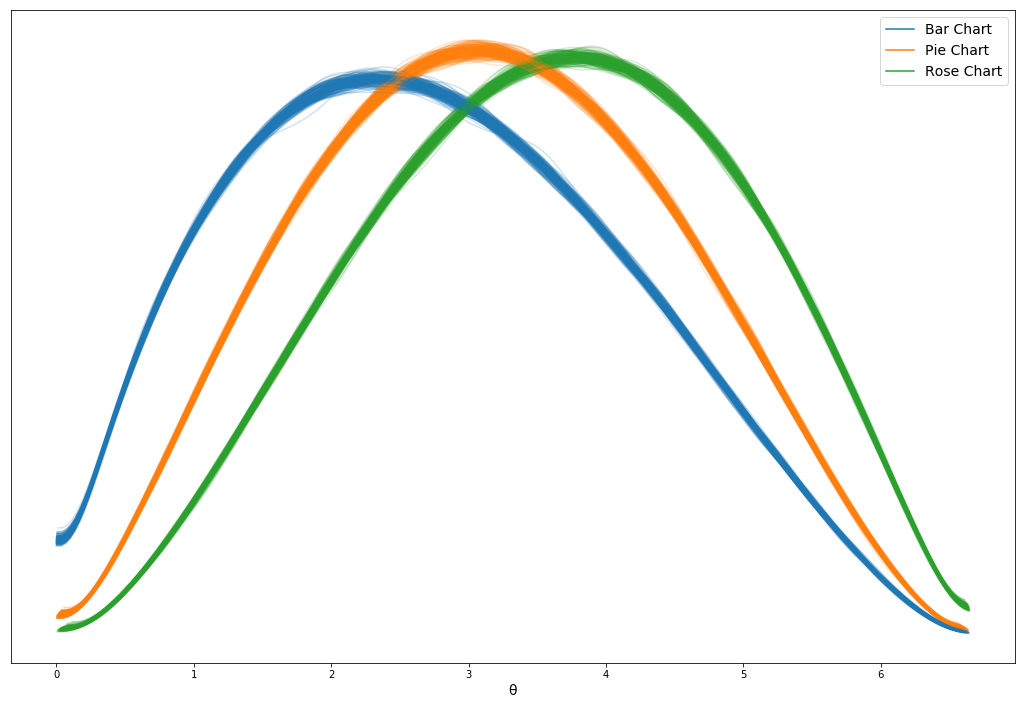

In [119]:
_, ax = plt.subplots(figsize=(18, 12))

for m_0, m_1, m_2 in zip(ppc_0['yl'].T, ppc_1['yl'].T, ppc_2['yl'].T):
    pm.kdeplot(m_0 * 6.646, ax=ax, alpha=0.2, color='C0') # return back to the scale we used before normalization
    pm.kdeplot(m_1 * 6.646, ax=ax, alpha=0.2, color='C1')
    pm.kdeplot(m_2 * 6.646, ax=ax, alpha=0.2, color='C2')
    
ax.plot([], label='Bar Chart')
ax.plot([], label='Pie Chart')
ax.plot([], label='Rose Chart')
ax.legend(fontsize=14)
ax.set_xlabel(u'θ', fontsize=14)
ax.set_yticks([]);